# Pharmacophore Input Preparation (RDKit + PyTorch Geometric)

This script sets up the initial environment and dependencies for processing a molecular structure—likely related to a pharmacophore—using RDKit and PyTorch Geometric. It's designed to work with the PharmaDiff framework and prepare the required molecular data for downstream tasks such as graph construction, feature extraction, or pharmacophore-based inpainting.

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data
import pharmadiff.datasets.dataset_utils as dataset_utils


from pharmadiff.datasets.pharmacophore_utils import get_features_factory



### Pharmacophore Feature Encoding
This section defines the pharmacophore types and atom encodings used in the model. These are essential for filtering relevant chemical features and encoding atom types as numerical input for neural networks.

In [22]:

PHARMACOPHORE_FAMILES_TO_KEEP= ('Aromatic', 'Hydrophobe', 'PosIonizable', 'Acceptor', 'Donor', 
                                 'LumpedHydrophobe')


full_atom_encoder = {'H': 0, 'B': 1, 'C': 2, 'N': 3, 'O': 4, 'F': 5, 'Al': 6, 'Si': 7,
                     'P': 8, 'S': 9, 'Cl': 10, 'As': 11, 'Br': 12, 'I': 13, 'Hg': 14, 'Bi': 15}


FAMILY_MAPPING = {'Aromatic': 1, 'Hydrophobe': 2, 'PosIonizable': 3,
                  'Acceptor': 4, 'Donor': 5, 'LumpedHydrophobe': 6}


### make_pharmacophore() Function

This function transforms selected RDKit pharmacophore features into a structured graph data format (torch_geometric.data.Data). It associates pharmacophore types and coordinates with atoms in a molecule, enabling the use of this information in graph neural networks for tasks like conditional molecule generation or evaluation.

In [23]:

def make_pharmacophore(selected_features, mol, pos_mean):
    
    feat_arr = np.empty(0)
    idx_arr_list = []
    coord_arr = np.empty(0)


    
    for f in selected_features:
        idx_arr = np.empty(0)
        if len(f.GetAtomIds()) > 1:
            for idx in f.GetAtomIds():
                idx_arr = np.append(idx_arr, np.array(idx))

        else:
            idx_arr = np.append(idx_arr, np.array(list(f.GetAtomIds())))
                
            
        feat_arr = np.append(feat_arr, np.array(FAMILY_MAPPING[f.GetFamily()]))
        coord_arr= np.append(coord_arr, np.array(f.GetPos(confId=f.GetActiveConformer())))
        idx_arr_list.append(idx_arr)
        
    coord_arr = coord_arr.reshape(-1, 3)


        
    n = mol.GetNumAtoms()

    feat_array = np.zeros(n)
    coord_array = np.zeros((n, 3))
    mask_array = np.zeros(n)
    

    
    for i, idx_list in enumerate(idx_arr_list):
        for idx in idx_list:
            feat_array[int(idx)] = feat_arr[i]
            coord_array[int(idx)] = coord_arr[i]
            mask_array[int(idx)] = 1
        
    coord_array = torch.Tensor(coord_array).float()

    coord_array = coord_array - pos_mean    
    pharma_feat = torch.Tensor(feat_array).long()
    mask_array = torch.Tensor(mask_array).long()
    #coord_array = coord_array - torch.mean(coord_array, dim=0, keepdim=True)
    coord_array = coord_array  * mask_array.unsqueeze(-1)

    pharma = Data(x = pharma_feat, pos = coord_array, y=mask_array)

    return pharma
        

#### Molecule Loading from SDF
This section loads the ligand structure from an .sdf file, using RDKit’s SDMolSupplier.


In [24]:
sdf_file = f"ligand_6b8y.sdf"  # Replace with your SDF file name

supplier = Chem.SDMolSupplier(sdf_file, sanitize=False)

mol = next(supplier)  # Use mol = supplier[0] if you are sure the file isn't empty4
Chem.SanitizeMol(mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

#### Visualize Molecule and Inspect Atom Coordinates
This section processes the loaded molecule by removing hydrogens, assigning atom indices, rendering a 2D image with annotated atom labels, and printing 3D coordinates for each atom.

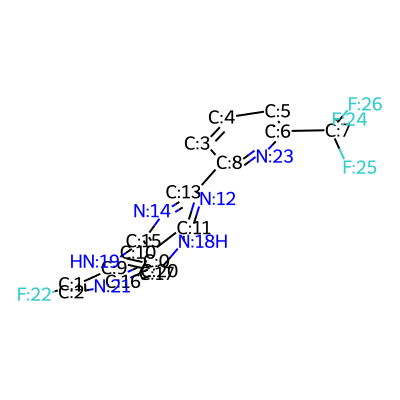

Atom 0 (C): x=4.156, y=7.382, z=3.021
Atom 1 (C): x=1.896, y=6.644, z=3.227
Atom 2 (C): x=1.907, y=6.388, z=1.860
Atom 3 (C): x=5.959, y=11.173, z=4.124
Atom 4 (C): x=6.755, y=12.011, z=3.365
Atom 5 (C): x=8.069, y=12.212, z=3.729
Atom 6 (C): x=8.557, y=11.557, z=4.849
Atom 7 (C): x=10.013, y=11.586, z=5.230
Atom 8 (C): x=6.509, y=10.553, z=5.245
Atom 9 (C): x=3.036, y=7.165, z=3.829
Atom 10 (C): x=4.213, y=7.661, z=7.303
Atom 11 (C): x=5.238, y=8.451, z=7.943
Atom 12 (N): x=5.979, y=9.390, z=7.321
Atom 13 (C): x=5.669, y=9.606, z=6.029
Atom 14 (N): x=4.685, y=8.996, z=5.353
Atom 15 (C): x=3.984, y=8.032, z=5.946
Atom 16 (C): x=3.729, y=6.723, z=8.280
Atom 17 (C): x=4.409, y=6.980, z=9.428
Atom 18 (N): x=5.291, y=8.015, z=9.234
Atom 19 (N): x=3.043, y=7.371, z=5.215
Atom 20 (C): x=4.077, y=7.067, z=1.675
Atom 21 (N): x=2.982, y=6.578, z=1.089
Atom 22 (F): x=0.853, y=6.311, z=4.032
Atom 23 (N): x=7.793, y=10.754, z=5.610
Atom 24 (F): x=10.206, y=11.945, z=6.509
Atom 25 (F): x=10.552, y=

In [25]:
mol = Chem.RemoveHs(mol)

if mol:
    # Add atom indices
    for atom in mol.GetAtoms():
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

    # Draw the molecule with atom numbering
    img = Draw.MolToImage(mol, size=(400, 400))
    img.show()
else:
    print("No valid molecule found in the SDF file.")
    

conf = mol.GetConformer()

for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    pos = conf.GetAtomPosition(idx)
    print(f"Atom {idx} ({atom.GetSymbol()}): x={pos.x:.3f}, y={pos.y:.3f}, z={pos.z:.3f}")

### Extract Pharmacophoric Features from Molecule
This section prepares the molecule for pharmacophore extraction, generates features using RDKit’s chemical feature factory, and selects a subset of features to use in downstream applications (e.g., PharmaDiff input preparation).

In [26]:
Chem.GetSSSR(mol)  # Optional: Ensure ring info is available
Chem.SanitizeMol(mol)
mol = Chem.AddHs(mol)

feature_factory, keep_featnames = get_features_factory(PHARMACOPHORE_FAMILES_TO_KEEP)

# Extract features
rawFeats = feature_factory.GetFeaturesForMol(mol, confId=-1)

# Print features
for f in rawFeats:
    print(f"Feature: {f.GetFamily()}, Atoms: {f.GetAtomIds()}, coords: {np.array(f.GetPos(confId=f.GetActiveConformer()))}")


#### Select features
selected_indeces =  [3, 5, 10, 12]
selected_features = [rawFeats[i] for i in selected_indeces]


Feature: Donor, Atoms: (12,), coords: [5.979 9.39  7.321]
Feature: Donor, Atoms: (18,), coords: [5.291 8.015 9.234]
Feature: Donor, Atoms: (19,), coords: [3.043 7.371 5.215]
Feature: Acceptor, Atoms: (12,), coords: [5.979 9.39  7.321]
Feature: Acceptor, Atoms: (14,), coords: [4.685 8.996 5.353]
Feature: Acceptor, Atoms: (21,), coords: [2.982 6.578 1.089]
Feature: Acceptor, Atoms: (22,), coords: [0.853 6.311 4.032]
Feature: Acceptor, Atoms: (23,), coords: [ 7.793 10.754  5.61 ]
Feature: Aromatic, Atoms: (10, 11, 18, 17, 16), coords: [4.576  7.566  8.4376]
Feature: Aromatic, Atoms: (0, 9, 1, 2, 21, 20), coords: [3.009      6.87066667 2.45016667]
Feature: Aromatic, Atoms: (3, 4, 5, 6, 23, 8), coords: [ 7.27366667 11.37666667  4.487     ]
Feature: Aromatic, Atoms: (10, 11, 12, 13, 14, 15), coords: [4.96133333 8.68933333 6.64916667]
Feature: Hydrophobe, Atoms: (0,), coords: [4.156 7.382 3.021]
Feature: Hydrophobe, Atoms: (3,), coords: [ 5.959 11.173  4.124]
Feature: Hydrophobe, Atoms: (4,),

In [35]:

## Print selected features
for f in selected_features:
    print(f"Feature: {f.GetFamily()}, Atoms: {f.GetAtomIds()}, coords: {np.array(f.GetPos())}")

Feature: Acceptor, Atoms: (12,), coords: [5.979 9.39  7.321]
Feature: Acceptor, Atoms: (21,), coords: [2.982 6.578 1.089]
Feature: Aromatic, Atoms: (3, 4, 5, 6, 23, 8), coords: [ 7.27366667 11.37666667  4.487     ]
Feature: Hydrophobe, Atoms: (0,), coords: [4.156 7.382 3.021]


#### Full Molecule and Pharmacophore Preprocessing Pipeline
This block processes a molecule by cleaning, sanitizing, converting it into a graph representation, extracting pharmacophore features, and preparing pharmacophore graph data — all while removing hydrogens for model readiness.

In [36]:

mol = Chem.RemoveHs(mol)
Chem.SanitizeMol(mol)
Chem.Kekulize(mol)

mol_data, pos_mean = dataset_utils.mol_to_torch_geometric(mol, full_atom_encoder, Chem.MolToSmiles(mol))

pharma_data = make_pharmacophore(selected_features, mol, pos_mean)

mol_data, pharma_data  = dataset_utils.remove_hydrogens(mol_data, pharma_data)


#### Batch Graphs and Save as Pickle File
This section demonstrates how to batch molecular and pharmacophore graph data for model input and save the resulting batch in a .pkl file for later use.

In [37]:
from torch_geometric.data import Batch

mol_batch = batch = Batch.from_data_list([mol_data])
pharma_batch = Batch.from_data_list([pharma_data])

data = {'ligand': mol_batch, 'pharmacophore': pharma_batch}



## if more than one pharmacophore: you need to collate
import pickle
with open('6b8y.pkl', 'wb') as f:
    pickle.dump(data, f)